#**Classification Dataset Stroke**

##**Import Library and Read Dataset**

In [125]:
from sklearn.neural_network import MLPClassifier #classifier
from sklearn.linear_model import LogisticRegression #classifier
from sklearn.naive_bayes import GaussianNB #classifier
from sklearn.neighbors import KNeighborsClassifier #classifier
from sklearn.model_selection import train_test_split #evaluation
from sklearn.model_selection import LeaveOneOut #evaluation
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score #evaluation
from sklearn.metrics import classification_report #evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #evaluation
from sklearn.metrics import accuracy_score #evaluation
from sklearn.feature_selection import VarianceThreshold #feature selection
from sklearn.feature_selection import chi2 #feature selection
from sklearn.feature_selection import f_classif #feature selection
from sklearn.decomposition import PCA #Dimentionality Reduction
from sklearn.preprocessing import StandardScaler #preprocessing
from sklearn.preprocessing import MinMaxScaler #preprocessing
from sklearn.preprocessing import Normalizer #preprocessing
from sklearn.preprocessing import PolynomialFeatures #preprocessing
import numpy as np #preprocessing
import pandas as pd #preprocessing
import math #preprocessing
import matplotlib.pyplot as plt #plotting
from imblearn.over_sampling import SMOTE #oversampling data
from time import time #execute time
 
start = time()
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1nUnX4BJpVoFCFy4JXqUmCRqyuUWZTWuv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##**Analyzing Data**

In [126]:
#delete id
data.drop(['id'], inplace=True, axis=1)

In [127]:
#check dtype for each data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [128]:
#check descriptive statistics data
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


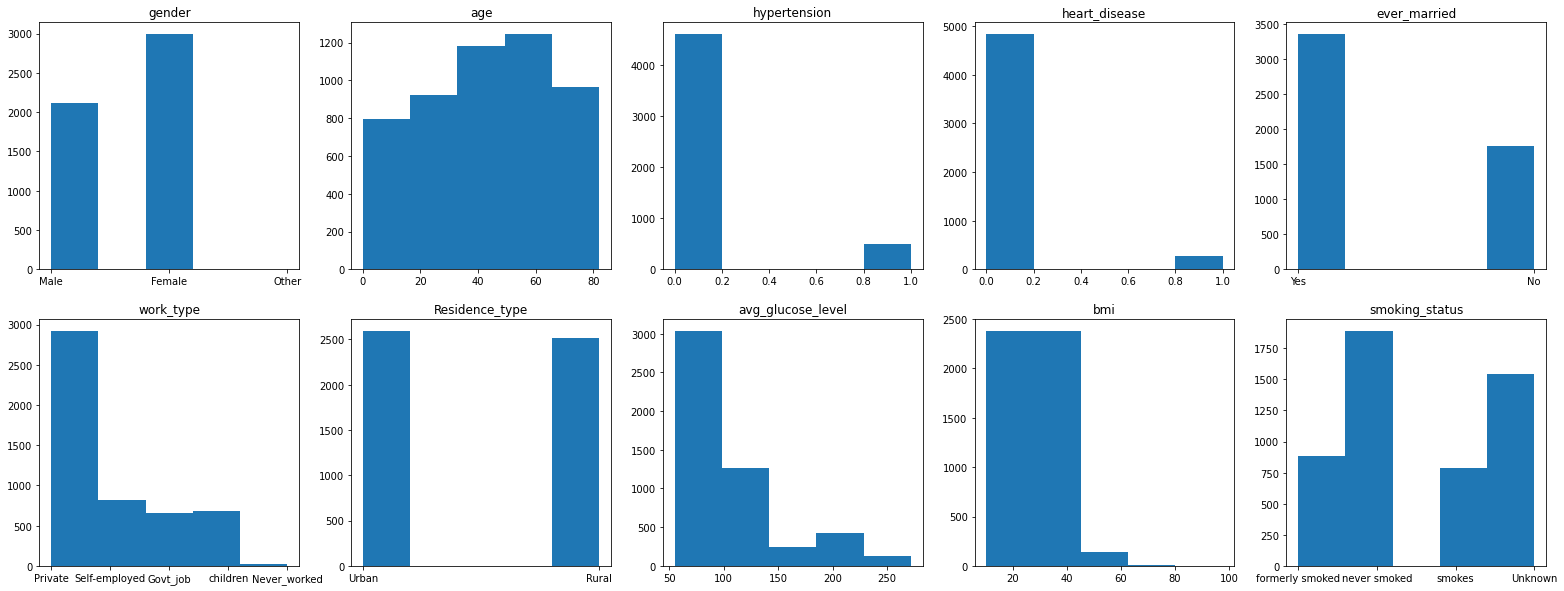

In [129]:
#display the distribution of data features
plt.subplots(figsize=(27,10))
for i in range(len(data.columns)-1):
  plt.subplot(2,5,i+1)
  plt.hist(data[data.columns[i]], bins=5)
  plt.title(data.columns[i])

Text(0.5, 1.0, 'stroke')

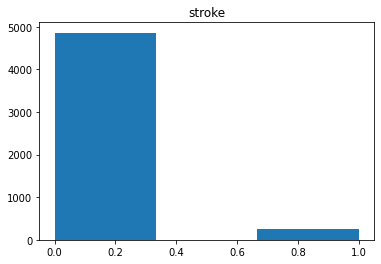

In [130]:
#display the distribution of data target
plt.hist(data[data.columns[-1]], bins=3)
plt.title(data.columns[-1])

##**Prepare Function**

In [131]:
#Function For Preprocessing Data -----------------------------------------------
#handling missing value
def handling_missing_value(data, handling='drop'):
  shape_before = data.shape
  if handling=='drop': data.dropna(inplace=True)
  elif handling=='median': data.fillna(data.median(), inplace=True)
  elif handling=='mean': data.fillna(data.mean(), inplace=True)
  elif handling=='mean': data.interpolate(inplace=True)
  print('Handling Missing Value - Successfully')
  print(f'Shape: (data{shape_before} => data{data.shape})')
  return data

#detecing and drop outliers - Interquartile Range
def drop_outliers(xtrain, ytrain):
  shape_before = xtrain.shape, ytrain.shape
  for i in range(len(xtrain[0])):
    feature = xtrain[:,i]
    q1, q3 = np.percentile(feature, [25,75])
    iqr = q3-q1
    lb, ub = q1-1.5*iqr, q3+1.5*iqr
    index_outliers = np.where((feature<lb) | (feature>ub))
    xtrain = np.delete(xtrain, index_outliers, axis=0)
    ytrain = np.delete(ytrain, index_outliers, axis=0)
  print('Drop Outliers - Successfully')
  print(f'Shape: (Feature{shape_before[0]} Target{shape_before[1]} => Feature{xtrain.shape} Target{ytrain.shape})')
  return xtrain, ytrain

#scaling - Standardization
def standard_scaler(xtrain, xtest):
  scaler = StandardScaler()
  scaler.fit(xtrain)
  xtrain = scaler.transform(xtrain)
  xtest = scaler.transform(xtest)
  print('Standard Scaling - Successfully')
  return xtrain, xtest


#scaling - MinMax
def min_max_scaler(xtrain, xtest, scale=(0,1)):
  scaler = MinMaxScaler(feature_range=scale)
  scaler.fit(xtrain)
  xtrain = scaler.transform(xtrain)
  xtest = scaler.transform(xtest)
  print('MinMax Scaling - Successfully')
  return xtrain, xtest


#Normalization Data
def normalization(xtrain, xtest, n='l2'):
  transformer = Normalizer(norm=n)
  transformer.fit(xtrain)
  xtrain = transformer.transform(xtrain)
  xtest = transformer.transform(xtest)
  print('Normalization Data - Successfully')
  return xtrain, xtest


#Generating Polynomial Features
def generate_polynomial_features(xtrain, xtest, degree=2):
  transformer = PolynomialFeatures(degree=2, include_bias=False)
  transformer.fit(xtrain)
  xtrain = transformer.transform(xtrain)
  xtest = transformer.transform(xtest)
  print('Generating Polynomial Features - Successfully')
  return xtrain, xtest

In [132]:
#Function for Evaluation ------------------------------------------------------
#Confusion Matrix
def display_cm(ytest, ypred, xtest=None, plot="no", model=None, target_names=None):
  if plot=="no":
    cm = confusion_matrix(ytest, ypred)
    ncm = confusion_matrix(ytest, ypred, normalize='true')
    print(f'Confusion Matrix:\n{cm}\n')
    print(f'Normalized Confusion Matrix:\n{ncm}\n')
    
  elif plot=="yes":
    plot_confusion_matrix(model, xtest, ytest, display_labels=target_names, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    plot_confusion_matrix(model, xtest, ytest, display_labels=target_names, cmap='Blues', normalize='true')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    print('')

#Classificastion Report
def display_cr(ytest, ypred, target_names):
  print(f'Classification Report :\n{classification_report(ytest, ypred, target_names=target_names, zero_division=0)}')

##**General Preprocessing Data**

In [133]:
#encoding categorical
for i in data.columns:
  if(data[i].dtype == object):
    categorical = data[i].unique()
    encode = [*range(len(categorical))]
    mapper = dict(zip(categorical, encode))
    data.replace(mapper, inplace=True)
    print(f'map {i}: {mapper}')

map gender: {'Male': 0, 'Female': 1, 'Other': 2}
map ever_married: {'Yes': 0, 'No': 1}
map work_type: {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}
map Residence_type: {'Urban': 0, 'Rural': 1}
map smoking_status: {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}


In [134]:
#check dtype for each features after encoding categorical
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   int64  
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 439.3 KB


In [135]:
#check missing value
print(f'Missing value:\n{data.isnull().sum()}')

Missing value:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [136]:
#handling missing value with median
data = handling_missing_value(data, handling='median')

Handling Missing Value - Successfully
Shape: (data(5110, 11) => data(5110, 11))


outliers gender: 0
outliers age: 0
outliers hypertension: 498
outliers heart_disease: 276
outliers ever_married: 0
outliers work_type: 0
outliers Residence_type: 0
outliers avg_glucose_level: 627
outliers bmi: 126
outliers smoking_status: 0

total outliers: 1184


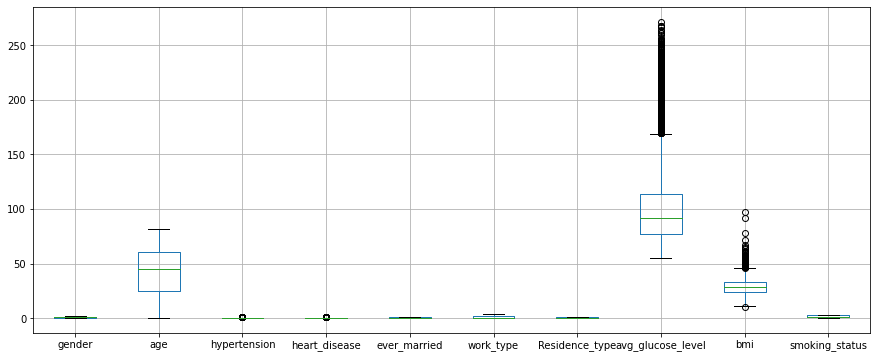

In [137]:
#check outliers features
outliers = []
for i in range (len(data.columns[:-1])):
  feature = data.iloc[:,i]
  q1, q3 = np.percentile(feature, [25,75])
  iqr = q3-q1
  lb, ub = q1-1.5*iqr, q3+1.5*iqr
  index_outliers = np.where((feature<lb) | (feature>ub))
  outliers.extend(index_outliers[0])
  print(f'outliers {data.columns[i]}: {len(index_outliers[0])}')

outliers = set(outliers)
print(f'\ntotal outliers: {len(outliers)}')
data.iloc[:,:-1].boxplot(figsize=(15,6))

In [138]:
#display data
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,1,61.0,0,0,0,1,1,202.21,28.1,1,1
2,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1,79.0,1,0,0,1,1,174.12,24.0,1,1


In [139]:
#get features names and target names
features_names = data.columns[0:-1].tolist()
target_names = ['no', 'yes']
print(f'Features names: {features_names}')
print(f'Target names: {target_names}')

Features names: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Target names: ['no', 'yes']


In [140]:
#Separate features data and labels data
features = data.values[:,0:-1]
target = data.values[:,-1]
print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

Features shape: (5110, 10)
Target shape: (5110,)


In [141]:
#Resampling with Oversampling Data
smote = SMOTE(random_state=1)
features_resampled, target_resampled = smote.fit_resample(features, target)
print(f'Features after oversampling shape: {features_resampled.shape}')
print(f'Target after oversampling shape: {target_resampled.shape}')

Features after oversampling shape: (9722, 10)
Target after oversampling shape: (9722,)


Text(0.5, 1.0, 'stroke')

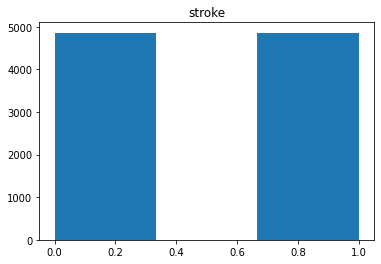

In [142]:
#Display the distribution of data target
plt.hist(target_resampled, bins=3)
plt.title(data.columns[-1])

##**Classification: k-Nearest Neighbors (KNN)**

###**Scenario 1**

In [143]:
#split data into training data and testing data
xtrain_knn, xtest_knn, ytrain_knn, ytest_knn = train_test_split(features, target, test_size=0.3, stratify=target,  random_state=1)
print(f'xtrain shape: {xtrain_knn.shape}')
print(f'ytrain shape: {ytrain_knn.shape}')
print(f'xtest shape: {xtest_knn.shape}')
print(f'ytest shape: {ytest_knn.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [144]:
#Preprocessing Data
xtrain_knn, ytrain_knn = drop_outliers(xtrain_knn, ytrain_knn)
xtrain_knn, xtest_knn = standard_scaler(xtrain_knn, xtest_knn)

Drop Outliers - Successfully
Shape: (Feature(3577, 10) Target(3577,) => Feature(2743, 10) Target(2743,))
Standard Scaling - Successfully


In [145]:
#training with k = sqrt(n)
k = round(math.sqrt(xtrain_knn.shape[0]))
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(xtrain_knn, ytrain_knn)
ypred_knn = knn.predict(xtest_knn)
acc = 100*accuracy_score(ytest_knn, ypred_knn)
print(f'k: {k}, accuracy: {acc:g}%')

k: 52, accuracy: 95.1076%


Highest mean accuracy:
k: 6, accuracy: 95.1076%


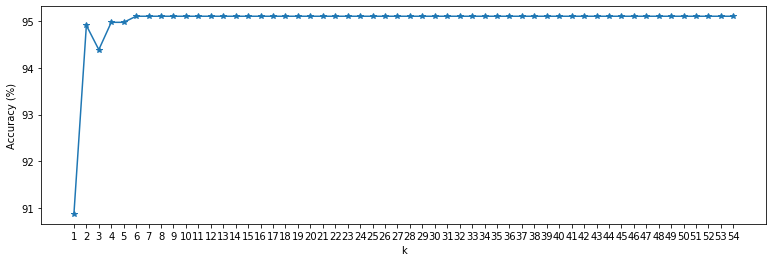

In [146]:
#training with k = [1,54]
list_acc = []
rangeK = range(1,55)
for k in rangeK:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xtrain_knn, ytrain_knn)
  ypred_knn = knn.predict(xtest_knn)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  list_acc.append(acc)

print(f'Highest mean accuracy:\nk: {list_acc.index(max(list_acc))+1}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(rangeK, list_acc, '-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

In [147]:
#training with k = 6
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(xtrain_knn, ytrain_knn)
ypred_knn = knn.predict(xtest_knn)
acc = 100*accuracy_score(ytest_knn, ypred_knn)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.1076%


In [148]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_knn, ypred_knn)
display_cr(ytest_knn, ypred_knn, target_names)

Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [149]:
#split data into trainding ata, validation data and testing data
xtrain_knn, xtest_knn, ytrain_knn, ytest_knn = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
xtrain_knn, xval_knn, ytrain_knn, yval_knn = train_test_split(xtrain_knn, ytrain_knn ,test_size=1533/3577, stratify=ytrain_knn, random_state=1)
print(f'xtrain shape: {xtrain_knn.shape}')
print(f'ytrain shape: {ytrain_knn.shape}')
print(f'xval shape: {xval_knn.shape}')
print(f'yval shape: {yval_knn.shape}')
print(f'xtest shape: {xtest_knn.shape}')
print(f'ytest shape: {ytest_knn.shape}')

xtrain shape: (2044, 10)
ytrain shape: (2044,)
xval shape: (1533, 10)
yval shape: (1533,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [150]:
#Preprocessing Data
xtrain_knn, ytrain_knn = drop_outliers(xtrain_knn, ytrain_knn)
_, xtest_knn = standard_scaler(xtrain_knn, xtest_knn)
xtrain_knn, xval_knn = standard_scaler(xtrain_knn, xval_knn)

Drop Outliers - Successfully
Shape: (Feature(2044, 10) Target(2044,) => Feature(1556, 10) Target(1556,))
Standard Scaling - Successfully
Standard Scaling - Successfully


Best validation score:
k: 5, accuracy: 95.1076%
Best testing score:
k: 6, accuracy: 95.1076%


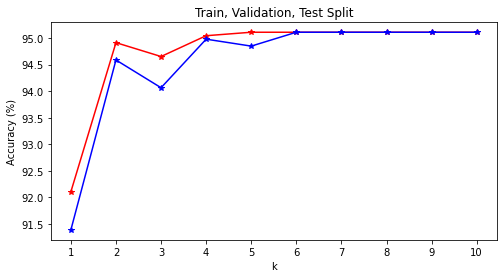

In [151]:
#training with k = [1,11]
list_acc_val = []
list_acc_test = []
rangeK = range(1,11)
for k in rangeK:
  #training
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xtrain_knn, ytrain_knn)
  #validation
  ypred_knn = knn.predict(xval_knn)
  acc_val = 100*accuracy_score(yval_knn, ypred_knn)
  list_acc_val.append(acc_val)
  #testing
  ypred_knn = knn.predict(xtest_knn)
  acc_test = 100*accuracy_score(ytest_knn, ypred_knn)
  list_acc_test.append(acc_test)


print(f'Best validation score:\nk: {list_acc_val.index(max(list_acc_val))+1}, accuracy: {max(list_acc_val):g}%')
print(f'Best testing score:\nk: {list_acc_test.index(max(list_acc_test))+1}, accuracy: {max(list_acc_test):g}%')
plt.figure(figsize=(8,4))
plt.plot(rangeK, list_acc_val, 'r-*')
plt.plot(rangeK, list_acc_test, 'b-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.title('Train, Validation, Test Split')
plt.show()

Highest mean accuracy:
k: 18, accuracy: 95.1076%


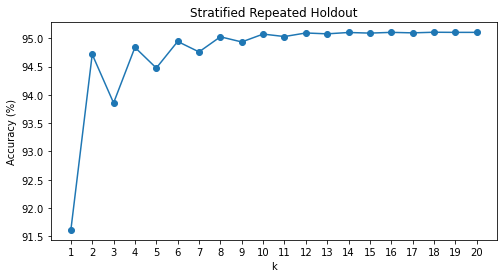

In [152]:
#Stratified Holdout
sss = list(StratifiedShuffleSplit(n_splits=30, test_size=0.3, random_state=1).split(features, target))
list_avg_acc = []
rangeK = range(1,21)
for k in rangeK:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(knn, features, target, cv=sss)
    list_avg_acc.append(100*acc.mean())

print(f'Highest mean accuracy:\nk: {list_avg_acc.index(max(list_avg_acc))+1}, accuracy: {max(list_avg_acc):g}%')
plt.figure(figsize=(8,4))
plt.plot(rangeK, list_avg_acc, '-o')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.title('Stratified Repeated Holdout')
plt.show()

Highest mean accuracy:
k: 14, accuracy: 95.1279%


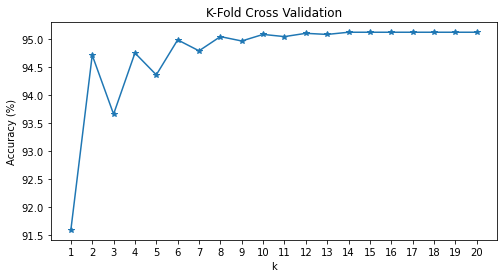

In [153]:
#K-Fold Cross Validation
list_avg_acc = []
rangeK = range(1,21)
for k in rangeK:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(knn, features, target, cv=30)
    list_avg_acc.append(100*acc.mean())

print(f'Highest mean accuracy:\nk: {list_avg_acc.index(max(list_avg_acc))+1}, accuracy: {max(list_avg_acc):g}%')
plt.figure(figsize=(8,4))
plt.plot(rangeK, list_avg_acc, '-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.title('K-Fold Cross Validation')
plt.show()

###**Scenario 2**

In [154]:
#split data into training data and testing data
xtrain_knn, xtest_knn, ytrain_knn, ytest_knn = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_knn.shape}')
print(f'ytrain shape: {ytrain_knn.shape}')
print(f'xtest shape: {xtest_knn.shape}')
print(f'ytest shape: {ytest_knn.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [155]:
#Preprocessing Data
xtrain_knn, xtest_knn = standard_scaler(xtrain_knn, xtest_knn)

Standard Scaling - Successfully


In [156]:
#Feature Selection
x2, pval = f_classif(xtrain_knn, ytrain_knn)
selected_col = np.where(pval<1.e-5)[0]

xtrain_knn_selected = xtrain_knn[:, selected_col]
xtest_knn_selected = xtest_knn[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_knn[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [7.66348373e-01 1.18805646e-51 6.09045104e-12 1.33783755e-16
 1.33570385e-10 4.40009038e-04 6.82175845e-01 1.47047684e-13
 2.01461271e-02 4.37292998e-06]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7, 9]


In [157]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_knn[1,:])+1):
  pca = PCA(i)
  ztrain_knn = pca.fit_transform(xtrain_knn)
  ztest_knn = pca.transform(xtest_knn)
  knn = KNeighborsClassifier()
  knn.fit(ztrain_knn, ytrain_knn)
  ypred_knn = knn.predict(ztest_knn)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 94.5858%
PCs 2, accuracy: 94.7815%
PCs 3, accuracy: 94.7162%
PCs 4, accuracy: 94.4553%
PCs 5, accuracy: 94.5858%
PCs 6, accuracy: 94.5858%
PCs 7, accuracy: 94.4553%
PCs 8, accuracy: 94.5205%
PCs 9, accuracy: 94.3901%
PCs 10, accuracy: 94.5205%
Optimum selected PCs: 2
Maximum accuracy: 94.7815%


In [158]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_knn = pca.fit_transform(xtrain_knn_selected)
  ztest_knn = pca.transform(xtest_knn_selected)
  knn = KNeighborsClassifier()
  knn.fit(ztrain_knn, ytrain_knn)
  ypred_knn = knn.predict(ztest_knn)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 94.8467%
PCs 2, accuracy: 94.5205%
PCs 3, accuracy: 94.7162%
PCs 4, accuracy: 94.3901%
PCs 5, accuracy: 94.4553%
PCs 6, accuracy: 94.4553%
Optimum selected PCs: 1
Maximum accuracy: 94.8467%


Highest accuracy:
k: 6, accuracy: 95.1076%


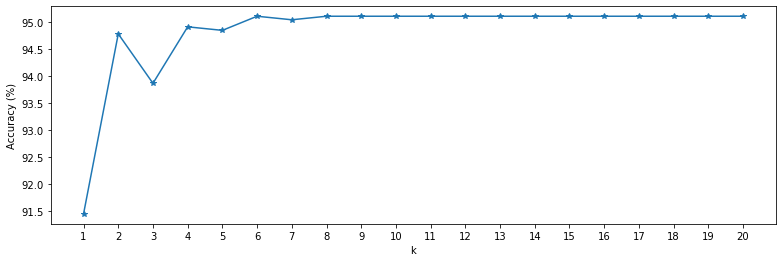

In [159]:
#training with k = [1,20] and PCA(1) with Feature Selection
list_acc = []
rangeK = range(1,21)
for k in rangeK:
  pca = PCA(1)
  ztrain_knn = pca.fit_transform(xtrain_knn_selected)
  ztest_nb = pca.transform(xtest_knn_selected)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(ztrain_knn, ytrain_knn)
  ypred_knn = knn.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  list_acc.append(acc)

print(f'Highest accuracy:\nk: {list_acc.index(max(list_acc))+1}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(rangeK, list_acc, '-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

In [160]:
#training with k = 6 and PCA(1) with Feature Selection
pca = PCA(1)
ztrain_knn = pca.fit_transform(xtrain_knn_selected)
ztest_nb = pca.transform(xtest_knn_selected)
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(ztrain_knn, ytrain_knn)
ypred_knn = knn.predict(ztest_nb)
acc = 100*accuracy_score(ytest_knn, ypred_knn)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.1076%


In [161]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_knn, ypred_knn)
display_cr(ytest_knn, ypred_knn, target_names)

Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



###**Scenario 3**

In [162]:
#split data into training data and testing data
xtrain_knn, xtest_knn, ytrain_knn, ytest_knn = train_test_split(features_resampled, target_resampled, test_size=0.3, stratify=target_resampled, random_state=1)
print(f'xtrain shape: {xtrain_knn.shape}')
print(f'ytrain shape: {ytrain_knn.shape}')
print(f'xtest shape: {xtest_knn.shape}')
print(f'ytest shape: {ytest_knn.shape}')

xtrain shape: (6805, 10)
ytrain shape: (6805,)
xtest shape: (2917, 10)
ytest shape: (2917,)


In [163]:
#Preprocessing Data
xtrain_knn, xtest_knn = standard_scaler(xtrain_knn, xtest_knn)

Standard Scaling - Successfully


In [164]:
#Feature Selection
x2, pval = f_classif(xtrain_knn, ytrain_knn)
selected_col = np.where(pval<1.e-50)[0]

xtrain_knn_selected = xtrain_knn[:, selected_col]
xtest_knn_selected = xtest_knn[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_knn[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [2.23971349e-003 0.00000000e+000 1.08697163e-102 3.59344817e-093
 2.19689849e-156 6.20139603e-046 1.96264206e-004 3.80445959e-092
 1.31276965e-012 5.89347243e-039]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7]


Highest accuracy:
k: 1, accuracy: 95.5091%


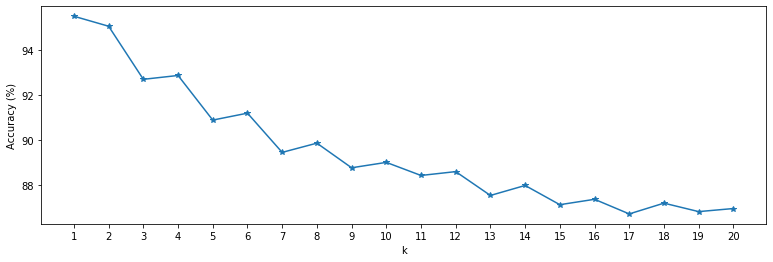

In [165]:
#training with k = [1,20] without Dimentional Reduction and Feature Selection
list_acc = []
rangeK = range(1,21)
for k in rangeK:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(xtrain_knn, ytrain_knn)
  ypred_knn = knn.predict(xtest_knn)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  list_acc.append(acc)

print(f'Highest accuracy:\nk: {list_acc.index(max(list_acc))+1}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(rangeK, list_acc, '-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.show()

In [166]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_knn[1,:])+1):
  pca = PCA(i)
  ztrain_knn = pca.fit_transform(xtrain_knn)
  ztest_nb = pca.transform(xtest_knn)
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(ztrain_knn, ytrain_knn)
  ypred_knn = knn.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 62.8385%
PCs 2, accuracy: 67.7751%
PCs 3, accuracy: 77.3055%
PCs 4, accuracy: 87.6586%
PCs 5, accuracy: 90.5725%
PCs 6, accuracy: 93.555%
PCs 7, accuracy: 95.0977%
PCs 8, accuracy: 95.4062%
PCs 9, accuracy: 95.6119%
PCs 10, accuracy: 95.5091%
Optimum selected PCs: 9
Maximum accuracy: 95.6119%


In [167]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_knn = pca.fit_transform(xtrain_knn_selected)
  ztest_nb = pca.transform(xtest_knn_selected)
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(ztrain_knn, ytrain_knn)
  ypred_knn = knn.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_knn, ypred_knn)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 67.0895%
PCs 2, accuracy: 77.374%
PCs 3, accuracy: 89.6469%
PCs 4, accuracy: 91.5324%
PCs 5, accuracy: 91.9095%
Optimum selected PCs: 5
Maximum accuracy: 91.9095%


In [168]:
#training with k = 1 and PCA(9) without Feature Selection
pca = PCA(9)
ztrain_knn = pca.fit_transform(xtrain_knn)
ztest_nb = pca.transform(xtest_knn)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(ztrain_knn, ytrain_knn)
ypred_knn = knn.predict(ztest_nb)
acc = 100*accuracy_score(ytest_knn, ypred_knn)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.6119%


In [169]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_knn, ypred_knn)
display_cr(ytest_knn, ypred_knn, target_names)

Confusion Matrix:
[[1345  113]
 [  15 1444]]

Normalized Confusion Matrix:
[[0.92249657 0.07750343]
 [0.01028101 0.98971899]]

Classification Report :
              precision    recall  f1-score   support

          no       0.99      0.92      0.95      1458
         yes       0.93      0.99      0.96      1459

    accuracy                           0.96      2917
   macro avg       0.96      0.96      0.96      2917
weighted avg       0.96      0.96      0.96      2917



Highest mean accuracy: 
k:2, accuracy:92.6865%


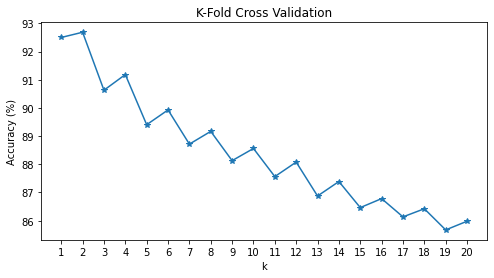

In [170]:
#K-Fold Cross Validation
list_avg_acc = []
rangeK = range(1,21)
for k in rangeK:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(knn, features_resampled, target_resampled, cv=30)
    list_avg_acc.append(100*acc.mean())

print(f'Highest mean accuracy: \nk:{list_avg_acc.index(max(list_avg_acc))+1}, accuracy:{max(list_avg_acc):g}%')
plt.figure(figsize=(8,4))
plt.plot(rangeK, list_avg_acc, '-*')
plt.xticks(rangeK)
plt.xlabel('k')
plt.ylabel('Accuracy (%)')
plt.title('K-Fold Cross Validation')
plt.show()

##**Classification: Naive Bayes**


###**Scenario 1**

In [171]:
#split data into training data and testing data
xtrain_nb, xtest_nb, ytrain_nb, ytest_nb = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_nb.shape}')
print(f'ytrain shape: {ytrain_nb.shape}')
print(f'xtest shape: {xtest_nb.shape}')
print(f'ytest shape: {ytest_nb.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [172]:
#Preprocessing Data
xtrain_nb, ytrain_nb = drop_outliers(xtrain_nb, ytrain_nb)
xtrain_nb, xtest_nb = standard_scaler(xtrain_nb, xtest_nb)

Drop Outliers - Successfully
Shape: (Feature(3577, 10) Target(3577,) => Feature(2743, 10) Target(2743,))
Standard Scaling - Successfully


In [173]:
#training 
gnb = GaussianNB()
gnb.fit(xtrain_nb, ytrain_nb)
ypred_nb = gnb.predict(xtest_nb)
acc = 100*accuracy_score(ytest_nb, ypred_nb)
print(f'Accuracy: {acc:g}%')

Accuracy: 93.8682%


In [174]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_nb, ypred_nb)
display_cr(ytest_nb, ypred_nb, target_names)

Confusion Matrix:
[[1435   23]
 [  71    4]]

Normalized Confusion Matrix:
[[0.98422497 0.01577503]
 [0.94666667 0.05333333]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      0.98      0.97      1458
         yes       0.15      0.05      0.08        75

    accuracy                           0.94      1533
   macro avg       0.55      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



In [175]:
#split data into training data, validation data and testing data
xtrain_nb, xtest_nb, ytrain_nb, ytest_nb = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
xtrain_nb, xval_nb, ytrain_nb, yval_nb = train_test_split(xtrain_nb, ytrain_nb ,test_size=1533/3577, stratify=ytrain_nb, random_state=1)
print(f'xtrain shape: {xtrain_nb.shape}')
print(f'ytrain shape: {ytrain_nb.shape}')
print(f'xval shape: {xval_nb.shape}')
print(f'yval shape: {yval_nb.shape}')
print(f'xtest shape: {xtest_nb.shape}')
print(f'ytest shape: {ytest_nb.shape}')

xtrain shape: (2044, 10)
ytrain shape: (2044,)
xval shape: (1533, 10)
yval shape: (1533,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [176]:
#Preprocessing Data
xtrain_nb, ytrain_nb = drop_outliers(xtrain_nb, ytrain_nb)
_, xtest_nb = standard_scaler(xtrain_nb, xtest_nb)
xtrain_nb, xval_nb = standard_scaler(xtrain_nb, xval_nb)

Drop Outliers - Successfully
Shape: (Feature(2044, 10) Target(2044,) => Feature(1556, 10) Target(1556,))
Standard Scaling - Successfully
Standard Scaling - Successfully


In [177]:
#training 
gnb = GaussianNB()
gnb.fit(xtrain_nb, ytrain_nb)
#validation
ypred_nb = gnb.predict(xval_nb)
acc = 100*accuracy_score(yval_nb, ypred_nb)
print(f'Best validation accuracy: {acc:g}%')
#testing
ypred_nb = gnb.predict(xtest_nb)
acc = 100*accuracy_score(ytest_nb, ypred_nb)
print(f'Best testing accuracy: {acc:g}%')

Best validation accuracy: 91.7156%
Best testing accuracy: 91.1285%


In [178]:
#Stratified Holdout
sss = list(StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=1).split(features, target))

gnb = GaussianNB()
acc = cross_val_score(gnb, features, target, cv=sss)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 86.1187%


In [179]:
#K-Fold Cross Validation
gnb = GaussianNB()
acc = cross_val_score(gnb, features, target, cv=30)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 86.0477%


###**Scenario 2**

In [180]:
#split data into training data and testing data
xtrain_nb, xtest_nb, ytrain_nb, ytest_nb = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_nb.shape}')
print(f'ytrain shape: {ytrain_nb.shape}')
print(f'xtest shape: {xtest_nb.shape}')
print(f'ytest shape: {ytest_nb.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [181]:
#Preprocessing Data
xtrain_nb, xtest_nb = standard_scaler(xtrain_nb, xtest_nb)

Standard Scaling - Successfully


In [182]:
#Feature Selection
x2, pval = f_classif(xtrain_nb, ytrain_nb)
selected_col = np.where(pval<1.e-5)[0]

xtrain_nb_selected = xtrain_nb[:, selected_col]
xtest_nb_selected = xtest_nb[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_nb[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [7.66348373e-01 1.18805646e-51 6.09045104e-12 1.33783755e-16
 1.33570385e-10 4.40009038e-04 6.82175845e-01 1.47047684e-13
 2.01461271e-02 4.37292998e-06]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7, 9]


In [183]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_nb[1,:])+1):
  pca = PCA(i)
  ztrain_nb = pca.fit_transform(xtrain_nb)
  ztest_nb = pca.transform(xtest_nb)
  gnb = GaussianNB()
  gnb.fit(ztrain_nb, ytrain_nb)
  ypred_nb = gnb.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_nb, ypred_nb)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 93.7378%
PCs 3, accuracy: 93.6725%
PCs 4, accuracy: 92.3679%
PCs 5, accuracy: 90.4762%
PCs 6, accuracy: 89.3673%
PCs 7, accuracy: 89.4325%
PCs 8, accuracy: 89.8239%
PCs 9, accuracy: 89.8891%
PCs 10, accuracy: 89.8891%
Optimum selected PCs: 1
Maximum accuracy: 95.1076%


In [184]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_nb = pca.fit_transform(xtrain_nb_selected)
  ztest_nb = pca.transform(xtest_nb_selected)
  gnb = GaussianNB()
  gnb.fit(ztrain_nb, ytrain_nb)
  ypred_nb = gnb.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_nb, ypred_nb)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 93.4768%
PCs 3, accuracy: 89.8239%
PCs 4, accuracy: 89.3673%
PCs 5, accuracy: 89.3673%
PCs 6, accuracy: 89.4977%
Optimum selected PCs: 1
Maximum accuracy: 95.1076%


In [185]:
#Training with PCA(1) and Feature Selection
pca = PCA(1)
ztrain_nb = pca.fit_transform(xtrain_nb_selected)
ztest_nb = pca.transform(xtest_nb_selected)
gnb = GaussianNB()
gnb.fit(ztrain_nb, ytrain_nb)
ypred_nb = gnb.predict(ztest_nb)
acc = 100*accuracy_score(ytest_nb, ypred_nb)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.1076%


In [186]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_nb, ypred_nb)
display_cr(ytest_nb, ypred_nb, target_names)

Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



###**Scenario 3**

In [187]:
#split data into training data and testing data
xtrain_nb, xtest_nb, ytrain_nb, ytest_nb = train_test_split(features_resampled, target_resampled, test_size=0.3, stratify=target_resampled, random_state=1)
print(f'xtrain shape: {xtrain_nb.shape}')
print(f'ytrain shape: {ytrain_nb.shape}')
print(f'xtest shape: {xtest_nb.shape}')
print(f'ytest shape: {ytest_nb.shape}')

xtrain shape: (6805, 10)
ytrain shape: (6805,)
xtest shape: (2917, 10)
ytest shape: (2917,)


In [188]:
#Preprocessing Data
xtrain_nb, xtest_nb = standard_scaler(xtrain_nb, xtest_nb)

Standard Scaling - Successfully


In [189]:
#Feature Selection
x2, pval = f_classif(xtrain_nb, ytrain_nb)
selected_col = np.where(pval<1.e-50)[0]

xtrain_nb_selected = xtrain_nb[:, selected_col]
xtest_nb_selected = xtest_nb[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_nb[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [2.23971349e-003 0.00000000e+000 1.08697163e-102 3.59344817e-093
 2.19689849e-156 6.20139603e-046 1.96264206e-004 3.80445959e-092
 1.31276965e-012 5.89347243e-039]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7]


In [190]:
#Without Dimentional Reduction and Feature Selection
gnb = GaussianNB()
gnb.fit(xtrain_nb, ytrain_nb)
ypred_nb = gnb.predict(xtest_nb)
acc = 100*accuracy_score(ytest_nb, ypred_nb)
print(f'Accuracy: {acc:g}%')

Accuracy: 77.2369%


In [191]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_nb[1,:])+1):
  pca = PCA(i)
  ztrain_nb = pca.fit_transform(xtrain_nb)
  ztest_nb = pca.transform(xtest_nb)
  gnb = GaussianNB()
  gnb.fit(ztrain_nb, ytrain_nb)
  ypred_nb = gnb.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_nb, ypred_nb)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 69.3864%
PCs 2, accuracy: 69.7977%
PCs 3, accuracy: 71.0319%
PCs 4, accuracy: 73.363%
PCs 5, accuracy: 73.0202%
PCs 6, accuracy: 74.1172%
PCs 7, accuracy: 73.843%
PCs 8, accuracy: 73.8087%
PCs 9, accuracy: 72.9174%
PCs 10, accuracy: 77.3055%
Optimum selected PCs: 10
Maximum accuracy: 77.3055%


In [192]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_nb = pca.fit_transform(xtrain_nb_selected)
  ztest_nb = pca.transform(xtest_nb_selected)
  gnb = GaussianNB()
  gnb.fit(ztrain_nb, ytrain_nb)
  ypred_nb = gnb.predict(ztest_nb)
  acc = 100*accuracy_score(ytest_nb, ypred_nb)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 75.9685%
PCs 2, accuracy: 75.9685%
PCs 3, accuracy: 76.6541%
PCs 4, accuracy: 76.0713%
PCs 5, accuracy: 75.9342%
Optimum selected PCs: 3
Maximum accuracy: 76.6541%


In [193]:
#training with PCA(10) without Feature Selection
pca = PCA(10)
ztrain_nb = pca.fit_transform(xtrain_nb)
ztest_nb = pca.transform(xtest_nb)
gnb = GaussianNB()
gnb.fit(ztrain_nb, ytrain_nb)
ypred_nb = gnb.predict(ztest_nb)
acc = 100*accuracy_score(ytest_nb, ypred_nb)
print(f'Accuracy: {acc:g}%\n')

Accuracy: 77.3055%



In [194]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_nb, ypred_nb)
display_cr(ytest_nb, ypred_nb, target_names)

Confusion Matrix:
[[ 975  483]
 [ 179 1280]]

Normalized Confusion Matrix:
[[0.66872428 0.33127572]
 [0.12268677 0.87731323]]

Classification Report :
              precision    recall  f1-score   support

          no       0.84      0.67      0.75      1458
         yes       0.73      0.88      0.79      1459

    accuracy                           0.77      2917
   macro avg       0.79      0.77      0.77      2917
weighted avg       0.79      0.77      0.77      2917



In [195]:
#K-Fold Cross Validation
gnb = GaussianNB()
acc = cross_val_score(gnb, features_resampled, target_resampled, cv=30)
print(f'Accuracy: {100*acc.mean():g}%')

Accuracy: 76.8366%


##**Classification: Logistics Regression**


###**Scenario 1**

In [196]:
#split data into training data and testing data
xtrain_lr, xtest_lr, ytrain_lr, ytest_lr = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_lr.shape}')
print(f'ytrain shape: {ytrain_lr.shape}')
print(f'xtest shape: {xtest_lr.shape}')
print(f'ytest shape: {ytest_lr.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [197]:
#Preprocessing Data
xtrain_lr, ytrain_lr = drop_outliers(xtrain_lr, ytrain_lr)
xtrain_lr, xtest_lr = standard_scaler(xtrain_lr, xtest_lr)

Drop Outliers - Successfully
Shape: (Feature(3577, 10) Target(3577,) => Feature(2743, 10) Target(2743,))
Standard Scaling - Successfully


In [198]:
#training 
lr = LogisticRegression()
lr.fit(xtrain_lr, ytrain_lr)
ypred_lr = lr.predict(xtest_lr)
acc = 100*accuracy_score(ytest_lr, ypred_lr)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.1076%


In [199]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_lr, ypred_lr)
display_cr(ytest_lr, ypred_lr, target_names)

Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [200]:
#split data into training data, validation data and testing data
xtrain_lr, xtest_lr, ytrain_lr, ytest_lr = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
xtrain_lr, xval_lr, ytrain_lr, yval_lr = train_test_split(xtrain_lr, ytrain_lr ,test_size=1533/3577, stratify=ytrain_lr, random_state=1)
print(f'xtrain shape: {xtrain_lr.shape}')
print(f'ytrain shape: {ytrain_lr.shape}')
print(f'xval shape: {xval_lr.shape}')
print(f'yval shape: {yval_lr.shape}')
print(f'xtest shape: {xtest_lr.shape}')
print(f'ytest shape: {ytest_lr.shape}')

xtrain shape: (2044, 10)
ytrain shape: (2044,)
xval shape: (1533, 10)
yval shape: (1533,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [201]:
#Preprocessing Data
xtrain_lr, ytrain_lr = drop_outliers(xtrain_lr, ytrain_lr)
_, xtest_lr = standard_scaler(xtrain_lr, xtest_lr)
xtrain_lr, xval_lr = standard_scaler(xtrain_lr, xval_lr)

Drop Outliers - Successfully
Shape: (Feature(2044, 10) Target(2044,) => Feature(1556, 10) Target(1556,))
Standard Scaling - Successfully
Standard Scaling - Successfully


In [202]:
#training 
lr = LogisticRegression()
lr.fit(xtrain_lr, ytrain_lr)
#validation
ypred_lr = lr.predict(xval_lr)
acc = 100*accuracy_score(yval_lr, ypred_lr)
print(f'Best validation accuracy: {acc:g}%')
#testing
ypred_lr = lr.predict(xtest_lr)
acc = 100*accuracy_score(ytest_lr, ypred_lr)
print(f'Best testing accuracy: {acc:g}%')

Best validation accuracy: 95.1076%
Best testing accuracy: 95.1076%


In [203]:
#Stratified Holdout
sss = list(StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=1).split(features, target))

lr = LogisticRegression(max_iter=500)
acc = cross_val_score(lr, features, target, cv=sss)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 95.1076%


In [204]:
#K-Fold Cross Validation
lr = LogisticRegression(max_iter=500)
acc = cross_val_score(lr, features, target, cv=30)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 95.1082%


###**Scenario 2**

In [205]:
#split data into training data and testing data
xtrain_lr, xtest_lr, ytrain_lr, ytest_lr = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_lr.shape}')
print(f'ytrain shape: {ytrain_lr.shape}')
print(f'xtest shape: {xtest_lr.shape}')
print(f'ytest shape: {ytest_lr.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [206]:
#Preprocessing Data
xtrain_lr, xtest_lr = standard_scaler(xtrain_lr, xtest_lr)

Standard Scaling - Successfully


In [207]:
#Feature Selection
x2, pval = f_classif(xtrain_lr, ytrain_lr)
selected_col = np.where(pval<1.e-5)[0]

xtrain_lr_selected = xtrain_lr[:, selected_col]
xtest_lr_selected = xtest_lr[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_lr[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [7.66348373e-01 1.18805646e-51 6.09045104e-12 1.33783755e-16
 1.33570385e-10 4.40009038e-04 6.82175845e-01 1.47047684e-13
 2.01461271e-02 4.37292998e-06]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7, 9]


In [208]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_lr[1,:])+1):
  pca = PCA(i)
  ztrain_lr = pca.fit_transform(xtrain_lr)
  ztest_lr = pca.transform(xtest_lr)
  lr = LogisticRegression()
  lr.fit(ztrain_lr, ytrain_lr)
  ypred_lr = lr.predict(ztest_lr)
  acc = 100*accuracy_score(ytest_lr, ypred_lr)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 95.1729%
PCs 3, accuracy: 95.1729%
PCs 4, accuracy: 95.1729%
PCs 5, accuracy: 95.1729%
PCs 6, accuracy: 95.1729%
PCs 7, accuracy: 95.1729%
PCs 8, accuracy: 95.1076%
PCs 9, accuracy: 95.1076%
PCs 10, accuracy: 95.0424%
Optimum selected PCs: 2
Maximum accuracy: 95.1729%


In [209]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_lr = pca.fit_transform(xtrain_lr_selected)
  ztest_lr = pca.transform(xtest_lr_selected)
  lr = LogisticRegression()
  lr.fit(ztrain_lr, ytrain_lr)
  ypred_lr = lr.predict(ztest_lr)
  acc = 100*accuracy_score(ytest_lr, ypred_lr)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 95.1729%
PCs 3, accuracy: 95.1076%
PCs 4, accuracy: 95.1076%
PCs 5, accuracy: 95.1076%
PCs 6, accuracy: 95.1076%
Optimum selected PCs: 2
Maximum accuracy: 95.1729%


In [210]:
#Training with PCA(2) and Feature Selection
pca = PCA(2)
ztrain_lr = pca.fit_transform(xtrain_lr_selected)
ztest_lr = pca.transform(xtest_lr_selected)
lr = LogisticRegression()
lr.fit(ztrain_lr, ytrain_lr)
ypred_lr = lr.predict(ztest_lr)
acc = 100*accuracy_score(ytest_lr, ypred_lr)
print(f'Accuracy: {acc:g}%')

Accuracy: 95.1729%


In [211]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_lr, ypred_lr)
display_cr(ytest_lr, ypred_lr, target_names)

Confusion Matrix:
[[1458    0]
 [  74    1]]

Normalized Confusion Matrix:
[[1.         0.        ]
 [0.98666667 0.01333333]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.98      1458
         yes       1.00      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.98      0.51      0.50      1533
weighted avg       0.95      0.95      0.93      1533



###**Scenario 3**

In [212]:
#split data into training data and testing data
xtrain_lr, xtest_lr, ytrain_lr, ytest_lr = train_test_split(features_resampled, target_resampled, test_size=0.3, stratify=target_resampled, random_state=1)
print(f'xtrain shape: {xtrain_lr.shape}')
print(f'ytrain shape: {ytrain_lr.shape}')
print(f'xtest shape: {xtest_lr.shape}')
print(f'ytest shape: {ytest_lr.shape}')

xtrain shape: (6805, 10)
ytrain shape: (6805,)
xtest shape: (2917, 10)
ytest shape: (2917,)


In [213]:
#Preprocessing Data
xtrain_lr, xtest_lr = standard_scaler(xtrain_lr, xtest_lr)

Standard Scaling - Successfully


In [214]:
#Feature Selection
x2, pval = f_classif(xtrain_lr, ytrain_lr)
selected_col = np.where(pval<1.e-50)[0]

xtrain_lr_selected = xtrain_lr[:, selected_col]
xtest_lr_selected = xtest_lr[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_lr[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [2.23971349e-003 0.00000000e+000 1.08697163e-102 3.59344817e-093
 2.19689849e-156 6.20139603e-046 1.96264206e-004 3.80445959e-092
 1.31276965e-012 5.89347243e-039]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7]


In [215]:
#Without Dimentional Reduction and Feature Selection
lr = LogisticRegression(max_iter=500)
lr.fit(xtrain_lr, ytrain_lr)
ypred_lr = lr.predict(xtest_lr)
acc = 100*accuracy_score(ytest_lr, ypred_lr)
print(f'Accuracy: {acc:g}%')

Accuracy: 76.8255%


In [216]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_lr[1,:])+1):
  pca = PCA(i)
  ztrain_lr = pca.fit_transform(xtrain_lr)
  ztest_lr = pca.transform(xtest_lr)
  lr = LogisticRegression()
  lr.fit(ztrain_lr, ytrain_lr)
  ypred_lr = lr.predict(ztest_lr)
  acc = 100*accuracy_score(ytest_lr, ypred_lr)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 69.5235%
PCs 2, accuracy: 69.6606%
PCs 3, accuracy: 71.7861%
PCs 4, accuracy: 74.083%
PCs 5, accuracy: 75.0429%
PCs 6, accuracy: 76.1399%
PCs 7, accuracy: 76.9626%
PCs 8, accuracy: 76.8598%
PCs 9, accuracy: 76.8941%
PCs 10, accuracy: 76.8255%
Optimum selected PCs: 7
Maximum accuracy: 76.9626%


In [217]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_lr = pca.fit_transform(xtrain_lr_selected)
  ztest_lr = pca.transform(xtest_lr_selected)
  lr = LogisticRegression()
  lr.fit(ztrain_lr, ytrain_lr)
  ypred_lr = lr.predict(ztest_lr)
  acc = 100*accuracy_score(ytest_lr, ypred_lr)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 76.8598%
PCs 2, accuracy: 77.134%
PCs 3, accuracy: 76.9626%
PCs 4, accuracy: 77.2026%
PCs 5, accuracy: 76.8941%
Optimum selected PCs: 4
Maximum accuracy: 77.2026%


In [218]:
#Training with PCA(4) and Feature Selection
pca = PCA(4)
ztrain_lr = pca.fit_transform(xtrain_lr_selected)
ztest_lr = pca.transform(xtest_lr_selected)
lr = LogisticRegression()
lr.fit(ztrain_lr, ytrain_lr)
ypred_lr = lr.predict(ztest_lr)
acc = 100*accuracy_score(ytest_lr, ypred_lr)
print(f'Accuracy: {acc:g}%')

Accuracy: 77.2026%


In [219]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_lr, ypred_lr)
display_cr(ytest_lr, ypred_lr, target_names)

Confusion Matrix:
[[1048  410]
 [ 255 1204]]

Normalized Confusion Matrix:
[[0.71879287 0.28120713]
 [0.17477724 0.82522276]]

Classification Report :
              precision    recall  f1-score   support

          no       0.80      0.72      0.76      1458
         yes       0.75      0.83      0.78      1459

    accuracy                           0.77      2917
   macro avg       0.78      0.77      0.77      2917
weighted avg       0.78      0.77      0.77      2917



In [220]:
#K-Fold Cross Validation
lr = LogisticRegression(max_iter=500)
acc = cross_val_score(lr, features_resampled, target_resampled, cv=30)
print(f'Accuracy: {100*acc.mean():g}%')

Accuracy: 76.435%


##**Classification: Artificial Neural Network (ANN)**


###**Scenario 1**

In [221]:
#split data into training data and testing data
xtrain_ann, xtest_ann, ytrain_ann, ytest_ann = train_test_split(features, target, test_size=0.3, stratify=target,  random_state=1)
print(f'xtrain shape: {xtrain_ann.shape}')
print(f'ytrain shape: {ytrain_ann.shape}')
print(f'xtest shape: {xtest_ann.shape}')
print(f'ytest shape: {ytest_ann.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [222]:
#Preprocessing Data
xtrain_ann, ytrain_ann = drop_outliers(xtrain_ann, ytrain_ann)
xtrain_ann, xtest_ann = standard_scaler(xtrain_ann, xtest_ann)

Drop Outliers - Successfully
Shape: (Feature(3577, 10) Target(3577,) => Feature(2743, 10) Target(2743,))
Standard Scaling - Successfully


Highest accuracy:
layer:(9,3), accuracy: 95.1076%


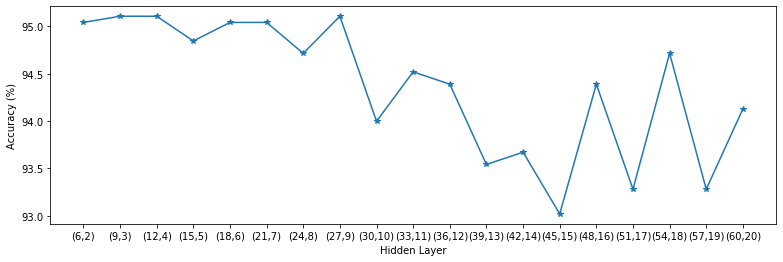

In [223]:
#training with Neuron = (ix3, i) -> i = [2,20] with activation relu
list_acc = []
list_layer = []
rangeN = range(2,21)
for i in rangeN:
  ann = MLPClassifier(hidden_layer_sizes=(i*3,i), max_iter=1500, random_state=1)
  ann.fit(xtrain_ann, ytrain_ann)
  ypred_ann = ann.predict(xtest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  list_acc.append(acc)
  list_layer.append(f'({i*3},{i})')

print(f'Highest accuracy:\nlayer:{list_layer[(list_acc.index(max(list_acc)))]}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(list_layer, list_acc, '-*')
plt.xticks(list_layer)
plt.xlabel('Hidden Layer')
plt.ylabel('Accuracy (%)')
plt.show()

Highest accuracy:
layer:(4,2), accuracy: 95.1076%


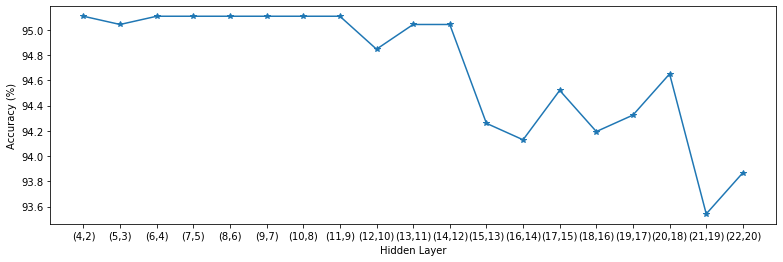

In [224]:
#training with Neuron = (i+2, i) -> i = [2,20] with activation relu
list_acc = []
list_layer = []
rangeN = range(2,21)
for i in rangeN:
  ann = MLPClassifier(hidden_layer_sizes=(i+2,i), max_iter=1500, random_state=1)
  ann.fit(xtrain_ann, ytrain_ann)
  ypred_ann = ann.predict(xtest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  list_acc.append(acc)
  list_layer.append(f'({i+2},{i})')

print(f'Highest accuracy:\nlayer:{list_layer[(list_acc.index(max(list_acc)))]}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(list_layer, list_acc, '-*')
plt.xticks(list_layer)
plt.xlabel('Hidden Layer')
plt.ylabel('Accuracy (%)')
plt.show()

Highest accuracy:
layer:(2), accuracy: 95.1076%


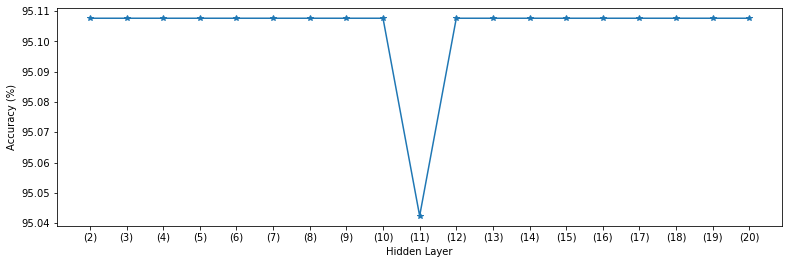

In [225]:
#training with Neuron = (i+2, i) -> i = [2,20] with activation relu
list_acc = []
list_layer = []
rangeN = range(2,21)
for i in rangeN:
  ann = MLPClassifier(hidden_layer_sizes=(i,), max_iter=1000, random_state=1)
  ann.fit(xtrain_ann, ytrain_ann)
  ypred_ann = ann.predict(xtest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  list_acc.append(acc)
  list_layer.append(f'({i})')

print(f'Highest accuracy:\nlayer:{list_layer[(list_acc.index(max(list_acc)))]}, accuracy: {max(list_acc):g}%')
plt.figure(figsize=(13,4))
plt.plot(list_layer, list_acc, '-*')
plt.xticks(list_layer)
plt.xlabel('Hidden Layer')
plt.ylabel('Accuracy (%)')
plt.show()

In [226]:
list_activation = ['logistic', 'tanh', 'identity']
for i in range(len(list_activation)):
  ann = MLPClassifier(hidden_layer_sizes=(9,3, ), activation=list_activation[i], max_iter=1500, alpha=0.001, random_state=1)
  ann.fit(xtrain_ann, ytrain_ann)
  ypred_ann = ann.predict(xtest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  print(f'activation: {list_activation[i]}, accuracy: {acc:g}%')
  display_cm(ytest_ann, ypred_ann)
  display_cr(ytest_ann, ypred_ann, target_names)

activation: logistic, accuracy: 95.1076%
Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

activation: tanh, accuracy: 94.1944%
Confusion Matrix:
[[1436   22]
 [  67    8]]

Normalized Confusion Matrix:
[[0.98491084 0.01508916]
 [0.89333333 0.10666667]]

Classification Report :
              precision    recall  f1-score   support

          no       0.96      0.98      0.97      1458
         yes       0.27      0.11      0.15        75

    accuracy                           0.94      1533
   macro avg       0.61      0.55      0.56      1533
weighted avg       0.92      0.94      0.93      1533

In [227]:
#split data into training data, validation data and testing data
xtrain_ann, xtest_ann, ytrain_ann, ytest_ann = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
xtrain_ann, xval_ann, ytrain_ann, yval_ann = train_test_split(xtrain_ann, ytrain_ann ,test_size=1533/3577, stratify=ytrain_ann, random_state=1)
print(f'xtrain shape: {xtrain_ann.shape}')
print(f'ytrain shape: {ytrain_ann.shape}')
print(f'xval shape: {xval_ann.shape}')
print(f'yval shape: {yval_ann.shape}')
print(f'xtest shape: {xtest_ann.shape}')
print(f'ytest shape: {ytest_ann.shape}')

xtrain shape: (2044, 10)
ytrain shape: (2044,)
xval shape: (1533, 10)
yval shape: (1533,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [228]:
#Preprocessing Data
xtrain_ann, ytrain_ann = drop_outliers(xtrain_ann, ytrain_ann)
_, xtest_ann = standard_scaler(xtrain_ann, xtest_ann)
xtrain_ann, xval_ann = standard_scaler(xtrain_ann, xval_ann)

Drop Outliers - Successfully
Shape: (Feature(2044, 10) Target(2044,) => Feature(1556, 10) Target(1556,))
Standard Scaling - Successfully
Standard Scaling - Successfully


In [229]:
#training 
ann = MLPClassifier(hidden_layer_sizes=(9, 3,), activation='tanh', max_iter=1500, alpha=0.00001, random_state=1)
ann.fit(xtrain_ann, ytrain_ann)
#validation
ypred_ann = ann.predict(xval_ann)
acc = 100*accuracy_score(yval_ann, ypred_ann)
print(f'Best validation accuracy: {acc:g}%')
#testing
ypred_ann = ann.predict(xtest_ann)
acc = 100*accuracy_score(ytest_ann, ypred_ann)
print(f'Best testing accuracy: {acc:g}%')

Best validation accuracy: 94.5858%
Best testing accuracy: 94.2596%


In [230]:
#Stratified Holdout
sss = list(StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=1).split(features, target))

ann = MLPClassifier(hidden_layer_sizes=(9, 3,), activation='tanh', max_iter=1500, alpha=0.00001, random_state=1)
acc = cross_val_score(ann, features, target, cv=sss)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 95.1076%


In [231]:
#K-Fold Cross Validation
ann = MLPClassifier(hidden_layer_sizes=(9, 3,), activation='tanh', max_iter=1500, alpha=0.00001, random_state=1)
acc = cross_val_score(ann, features, target, cv=30)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 95.1082%


###**Scenario 2**

In [232]:
#split data into training data and testing data
xtrain_ann, xtest_ann, ytrain_ann, ytest_ann = train_test_split(features, target, test_size=0.3, stratify=target, random_state=1)
print(f'xtrain shape: {xtrain_ann.shape}')
print(f'ytrain shape: {ytrain_ann.shape}')
print(f'xtest shape: {xtest_ann.shape}')
print(f'ytest shape: {ytest_ann.shape}')

xtrain shape: (3577, 10)
ytrain shape: (3577,)
xtest shape: (1533, 10)
ytest shape: (1533,)


In [233]:
#Preprocessing Data
xtrain_ann, xtest_ann = standard_scaler(xtrain_ann, xtest_ann)

Standard Scaling - Successfully


In [234]:
#Feature Selection
x2, pval = f_classif(xtrain_ann, ytrain_ann)
selected_col = np.where(pval<1.e-5)[0]

xtrain_ann_selected = xtrain_ann[:, selected_col]
xtest_ann_selected = xtest_ann[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_ann[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [7.66348373e-01 1.18805646e-51 6.09045104e-12 1.33783755e-16
 1.33570385e-10 4.40009038e-04 6.82175845e-01 1.47047684e-13
 2.01461271e-02 4.37292998e-06]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7, 9]


In [235]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_ann[1,:])+1):
  pca = PCA(i)
  ztrain_ann = pca.fit_transform(xtrain_ann)
  ztest_ann = pca.transform(xtest_ann)
  ann = MLPClassifier(max_iter=1500, random_state=1)
  ann.fit(ztrain_ann, ytrain_ann)
  ypred_ann = ann.predict(ztest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 95.1076%
PCs 3, accuracy: 95.1076%
PCs 4, accuracy: 95.1076%
PCs 5, accuracy: 95.1076%
PCs 6, accuracy: 95.1076%
PCs 7, accuracy: 94.9772%
PCs 8, accuracy: 94.9119%
PCs 9, accuracy: 94.3901%
PCs 10, accuracy: 93.6725%
Optimum selected PCs: 1
Maximum accuracy: 95.1076%


In [236]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_ann = pca.fit_transform(xtrain_ann_selected)
  ztest_ann = pca.transform(xtest_ann_selected)
  ann = MLPClassifier(max_iter=1500, random_state=1)
  ann.fit(ztrain_ann, ytrain_ann)
  ypred_ann = ann.predict(ztest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 95.1076%
PCs 2, accuracy: 95.1076%
PCs 3, accuracy: 95.1076%
PCs 4, accuracy: 95.1076%
PCs 5, accuracy: 95.1076%
PCs 6, accuracy: 94.9772%
Optimum selected PCs: 1
Maximum accuracy: 95.1076%


In [237]:
#Training with PCA(1) and Feature Selection
pca = PCA(1)
ztrain_ann = pca.fit_transform(xtrain_ann_selected)
ztest_ann = pca.transform(xtest_ann_selected)
ann = MLPClassifier(hidden_layer_sizes=(9,3,), max_iter=1500, alpha=0.0001, random_state=1)
ann.fit(ztrain_ann, ytrain_ann)
ypred_ann = ann.predict(ztest_ann)
acc = 100*accuracy_score(ytest_ann, ypred_ann)
print(f'accuracy: {acc:g}%')

accuracy: 95.1076%


In [238]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_ann, ypred_ann)
display_cr(ytest_ann, ypred_ann, target_names)

Confusion Matrix:
[[1458    0]
 [  75    0]]

Normalized Confusion Matrix:
[[1. 0.]
 [1. 0.]]

Classification Report :
              precision    recall  f1-score   support

          no       0.95      1.00      0.97      1458
         yes       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



###**Scenario 3**

In [239]:
#split data into training data and testing data
xtrain_ann, xtest_ann, ytrain_ann, ytest_ann = train_test_split(features_resampled, target_resampled, test_size=0.3, stratify=target_resampled, random_state=1)
print(f'xtrain shape: {xtrain_ann.shape}')
print(f'ytrain shape: {ytrain_ann.shape}')
print(f'xtest shape: {xtest_ann.shape}')
print(f'ytest shape: {ytest_ann.shape}')

xtrain shape: (6805, 10)
ytrain shape: (6805,)
xtest shape: (2917, 10)
ytest shape: (2917,)


In [240]:
#Preprocessing Data
xtrain_ann, xtest_ann = standard_scaler(xtrain_ann, xtest_ann)

Standard Scaling - Successfully


In [241]:
#Feature Selection
x2, pval = f_classif(xtrain_ann, ytrain_ann)
selected_col = np.where(pval<1.e-50)[0]

xtrain_ann_selected = xtrain_ann[:, selected_col]
xtest_ann_selected = xtest_ann[:, selected_col]

print(f'P-value         : {pval}')
print(f'all columns     : {[*range(len(xtrain_ann[1,:]))]}')
print(f'Selected columns: {selected_col.tolist()}')

P-value         : [2.23971349e-003 0.00000000e+000 1.08697163e-102 3.59344817e-093
 2.19689849e-156 6.20139603e-046 1.96264206e-004 3.80445959e-092
 1.31276965e-012 5.89347243e-039]
all columns     : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected columns: [1, 2, 3, 4, 7]


In [242]:
#Without Dimentional Reduction and Feature Selection
ann = MLPClassifier(hidden_layer_sizes=(9,3,), activation='logistic', max_iter=1500, random_state=1)
ann.fit(xtrain_ann, ytrain_ann)
ypred_ann = ann.predict(xtest_ann)
acc = 100*accuracy_score(ytest_ann, ypred_ann)
print(f'Accuracy: {acc:g}%')

Accuracy: 89.5098%


In [243]:
#Dimentional Reduction without Feature Selection
r = 1
max_acc = 0
for i in range(1,len(xtrain_ann[1,:])+1):
  pca = PCA(i)
  ztrain_ann = pca.fit_transform(xtrain_ann)
  ztest_ann = pca.transform(xtest_ann)
  ann = MLPClassifier(hidden_layer_sizes=(9,3,), max_iter=1500, random_state=1)
  ann.fit(ztrain_ann, ytrain_ann)
  ypred_ann = ann.predict(ztest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 70.4834%
PCs 2, accuracy: 71.1004%
PCs 3, accuracy: 50.0171%
PCs 4, accuracy: 79.4652%
PCs 5, accuracy: 80.5279%
PCs 6, accuracy: 86.1502%
PCs 7, accuracy: 87.5557%
PCs 8, accuracy: 88.2413%
PCs 9, accuracy: 86.2873%
PCs 10, accuracy: 86.8701%
Optimum selected PCs: 8
Maximum accuracy: 88.2413%


In [244]:
#Dimentional Reduction with Feature Selection
r = 1
max_acc = 0
for i in range(1,len(selected_col)+1):
  pca = PCA(i)
  ztrain_ann = pca.fit_transform(xtrain_ann_selected)
  ztest_ann = pca.transform(xtest_ann_selected)
  ann = MLPClassifier(hidden_layer_sizes=(9,3,), activation='logistic', max_iter=1500, random_state=1)
  ann.fit(ztrain_ann, ytrain_ann)
  ypred_ann = ann.predict(ztest_ann)
  acc = 100*accuracy_score(ytest_ann, ypred_ann)
  print(f'PCs {i}, accuracy: {acc:g}%')
  if(acc>max_acc):
    r = i
    max_acc = acc
print(f'Optimum selected PCs: {r}')
print(f'Maximum accuracy: {max_acc:g}%')

PCs 1, accuracy: 76.517%
PCs 2, accuracy: 76.7227%
PCs 3, accuracy: 78.6424%
PCs 4, accuracy: 77.8882%
PCs 5, accuracy: 84.0932%
Optimum selected PCs: 5
Maximum accuracy: 84.0932%


In [245]:
#training with layer(100,100) Without Dimentional Reduction and Feature Selection
ann = MLPClassifier(hidden_layer_sizes=(300,100,), activation='logistic', max_iter=1500, random_state=1)
ann.fit(xtrain_ann, ytrain_ann)
ypred_ann = ann.predict(xtest_ann)
acc = 100*accuracy_score(ytest_ann, ypred_ann)
print(f'Accuracy: {acc:g}%')

Accuracy: 91.6695%


In [246]:
#Display Confusion Matrix and Classification Report
display_cm(ytest_ann, ypred_ann)
display_cr(ytest_ann, ypred_ann, target_names)

Confusion Matrix:
[[1313  145]
 [  98 1361]]

Normalized Confusion Matrix:
[[0.9005487  0.0994513 ]
 [0.06716929 0.93283071]]

Classification Report :
              precision    recall  f1-score   support

          no       0.93      0.90      0.92      1458
         yes       0.90      0.93      0.92      1459

    accuracy                           0.92      2917
   macro avg       0.92      0.92      0.92      2917
weighted avg       0.92      0.92      0.92      2917



In [247]:
#K-Fold Cross Validation
ann = MLPClassifier(hidden_layer_sizes=(9, 3,), activation='logistic', max_iter=1500, random_state=1)
acc = cross_val_score(ann, features_resampled, target_resampled, cv=30)
print(f'Highest accuracy: {100*acc.mean():g}%')

Highest accuracy: 82.2472%


In [248]:
print(f'time taken: {round((time() - start)/60, 2)} minute') 

time taken: 19.32 minute
